# Structural measurements on kinases

1. dataclass for loading and working with data
2. functions for systematically generating data for multiple targets
3. application and results

## Code

### Imports

In [37]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
import os
from sympy import Plane, Point3D
import copy

import matplotlib as mpl
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt



### Dataclass

In [4]:

class molData:
    def __init__(self,path,data_section = 0):
        my_data = pd.read_table(path,skiprows=8,header=None,delim_whitespace=True,index_col=0)
        atoms = my_data.loc[:"@<TRIPOS>BOND"].iloc[:-1]
        atoms.columns = ["atomID","x","y","z","compound2",
                         "residueNR","residue","charge","mainChain"]
        resPattern = r"[A-Z]{3}[0-9]*"
        hohPattern = r"HOH[0-9]*"
        residueMask = atoms.loc[:,"residue"].str.match(resPattern,as_indexer=True).values
        hohMask = atoms.loc[:,"residue"].str.match(hohPattern,as_indexer=True).values
        self.other = atoms.loc[np.logical_not(residueMask)]
        self.water = atoms.loc[hohMask]
        self.chain = atoms.loc[np.logical_and(residueMask,np.logical_not(hohMask))]
        resDigest = self.chain.loc[:,"residue"].str.extract('(?P<residueType>[A-Z]{3})(?P<residueID>[0-9]*)')
        self.chain = self.chain.join(resDigest)
        self.chainIDGroups = self.chain.groupby(["residueID","atomID"])
        self.chainNRGroups = self.chain.groupby(["residueNR","atomID"])
        self.bonds = my_data.loc["@<TRIPOS>BOND":"@<TRIPOS>SUBSTRUCTURE"].iloc[1:-1]
        self.subst = my_data.loc["@<TRIPOS>SUBSTRUCTURE":].iloc[1:-2]

    def anchordistance(self,res1,res2): # fix
        coord1 = self.old_get_atom_coords(res1)
        coord2 = self.old_get_atom_coords(res2)
        return self.distance(coord1,coord2)
        
    def distance(self,coord1,coord2):
        return np.linalg.norm(coord1 - coord2)
    
    def old_get_atom_coords(self, residueID, anchor_atom=2):
        """
            extracts coordinates for target atom according to residue type 
        """
        residue = self.chainIDGroups.get_group((residueID))
        anchor = residue.iloc[anchor_atom]
        coords = anchor.loc["x":"z"]
        return np.array(coords).astype(np.float32)
    
    def get_atom_coords1(self, residueID, anchor_atom="CA"): # combine with 2 later
        anchor = self.chainIDGroups.get_group((residueID,anchor_atom))
        coords = anchor.loc[:,"x":"z"]
        return np.array(coords).astype(np.float32)

    def get_atom_coords2(self, residueNR, anchor_atom="CA"):
        try:
            anchor = self.chainNRGroups.get_group((residueNR,anchor_atom))
        except KeyError as e:
            e.args += (residueNR,anchor_atom,self.chainNRGroups.groups, )
            raise
        coords = anchor.loc[:,"x":"z"]
        result = np.array(coords.values).astype(np.float32)[0]
        return result
        
    def chi_angle(self,coords):
        plane1 = Plane(Point3D(coords[0]), Point3D(coords[1]), Point3D(coords[2]))
        plane2 = Plane(Point3D(coords[1]), Point3D(coords[2]), Point3D(coords[3]))
        return plane1.angle_between(plane2)
        
    def calculate_chi1(self,residue):
        Amcrd = self.get_atom_coords2(residue, "N")
        CAcrd = self.get_atom_coords2(residue, "CA")
        CBcrd = self.get_atom_coords2(residue, "CB")
        CGcrd = self.get_atom_coords2(residue, "CG")
        coords = (Amcrd, CAcrd, CBcrd, CGcrd)
        return self.chi_angle(coords).evalf()
    
    def calculate_chi2(self,residue):
        CAcrd = self.get_atom_coords2(residue, "CA")
        CBcrd = self.get_atom_coords2(residue, "CB")
        CGcrd = self.get_atom_coords2(residue, "CG")
        SDcrd = self.get_atom_coords2(residue, "SD")
        coords = (CAcrd, CBcrd, CGcrd, SDcrd)
        return self.chi_angle(coords).evalf()
    
    def chi_angles(self,residue):
        chi1 = self.calculate_chi1(str(residue))
        chi2 = self.calculate_chi2(str(residue))
        return [chi1, chi2]

    

### Mass calculation method

In [8]:

DATASECTIONS = {
    "complex": "/complex.mol2",
    "pocket": "/pocket.mol2"
}

MEASUREMENTS = {
    "distance": "distance",
    "angles": "chi_angles"
}

MEASID = {
    "distance": 0,
    "chi_angles": 1
}

def calculate_kinase_data(structure_path, data_section, measurement, res_ids=None):
    structures = pd.Series([name for name in os.listdir(structure_path) if os.path.isdir(structure_path + name)])
    structure_labels = structures.str.replace("chain","").str.lower().str.replace("_alt[ab]","")
    results = pd.DataFrame(index = structure_labels)
    if measurement == 0:
        results["measured"] = pd.Series()
    elif measurement == 1:
        results["chi1"] = pd.Series()
        results["chi2"] = pd.Series()
    fails = []

    for structure, structure_label in zip(structures,structure_labels):
        myurl = structure_path + structure + DATASECTIONS[data_section]
        mydata = molData(myurl,data_section)
        if measurement == 0:
            residueID1 = res_ids[0]
            residueID2 = res_ids[1]
            results.loc[structure_label,"measured"] = mydata.anchordistance(residueID1,residueID2)
        elif measurement == 1:
            if res_ids is None:
                res_ids = 45
            residueID = res_ids
            try:
                angles = mydata.chi_angles(residueID)
                results.loc[structure_label,"chi1"] = angles[0]
                results.loc[structure_label,"chi2"] = angles[1]
                print "chi angles measured for " + structure_label
            except KeyError as e:
                fails.append(structure_label)
                print "chi angles failed for " + structure_label
    return (results, fails)


def calculate_organism_data(organism_path,data_section,measurement,res_ids=None):
    kinases = pd.Series([name for name in os.listdir(organism_path) if os.path.isdir(organism_path + name)])
    measurement = MEASUREMENTS[measurement]
    measurement = MEASID[measurement]
    if measurement == 0:
        results = pd.DataFrame(columns = "measured")
    elif measurement == 1:
        results = pd.DataFrame(columns = ["chi1","chi2"])
    for kinase in kinases:
        print "starting on " + kinase
        kinase_path = organism_path + kinase + "/"
        kinase_data = calculate_kinase_data(kinase_path, data_section, measurement, res_ids)
        results = results.append(kinase_data[0])
    return results


## Calculate methionine gatekeeper chi angles

In [6]:
myurl1 = "/Users/matthias/Documents/hibit.in/KLIFS_LigandBound2/HUMAN/"
myurl2 = "/Users/matthias/Documents/hibit.in/KLIFS_LigandUnBound2/HUMAN/"
mydata = "pocket"
mymeasurement = "angles"




In [7]:
dataBound = calculate_organism_data(myurl1, mydata, mymeasurement)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [11]:
dataUnbound = calculate_organism_data(myurl2, mydata, mymeasurement)

starting on AKT2
chi angles failed for 1gzk_a
chi angles failed for 1gzn_a
chi angles failed for 1gzo_a
chi angles failed for 1mrv_a
chi angles failed for 1mry_a
starting on ALK
chi angles measured for 2yhv_a
starting on AMPKa1
chi angles measured for 4red_a
chi angles measured for 4red_b
starting on AMPKa2
chi angles measured for 2h6d_a
chi angles measured for 2h6d_a
chi angles measured for 2yza_a
starting on CaMK1a
chi angles measured for 4fgb_a
starting on CK1a
chi angles measured for 5fqd_c
chi angles measured for 5fqd_f
starting on CK1d
chi angles failed for 3uys_a
chi angles failed for 3uys_b
chi angles failed for 3uys_c
chi angles failed for 3uys_d
chi angles measured for 4tn6_b
chi angles measured for 4tn6_b
starting on CK1e
chi angles failed for 4hok_a
chi angles failed for 4hok_c
chi angles failed for 4hok_e
chi angles failed for 4hok_g
chi angles failed for 4hok_i
chi angles failed for 4hok_k
chi angles measured for 4hok_m
chi angles failed for 4hok_o
chi angles failed for 4

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [9]:
dataBound.to_csv("/Users/matthias/Documents/hibit.in/development/KinStruct/dataBound.csv")

In [17]:
dataUnbound.to_csv("/Users/matthias/Documents/hibit.in/development/KinStruct/dataUnbound.csv")

In [6]:
dataBound = pd.read_csv("/Users/matthias/Documents/hibit.in/development/KinStruct/dataBound.csv",
                        index_col = 0)
dataUnbound = pd.read_csv("/Users/matthias/Documents/hibit.in/development/KinStruct/dataUnbound.csv",
                          index_col = 0)

In [7]:
dataBound = dataBound.astype(np.float32)
dataUnbound = dataUnbound.astype(np.float32)

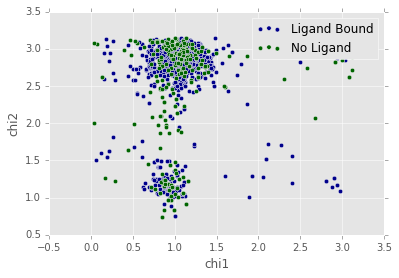

In [8]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax = dataBound.plot.scatter("chi1","chi2",color="DarkBlue",label="Ligand Bound", ax=ax)
ax = dataUnbound.plot.scatter("chi1","chi2",color="DarkGreen",label="No Ligand", ax=ax)
plt.show()
fig.savefig("/Users/matthias/Documents/hibit.in/development/KinStruct/chi_angles.png")

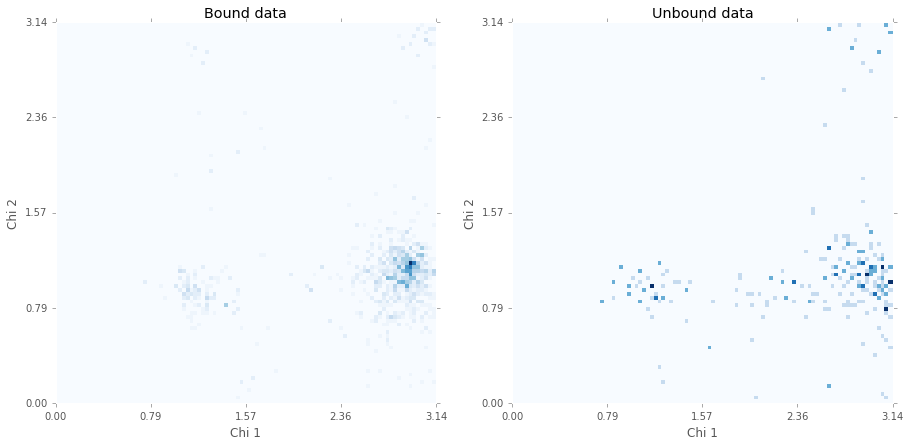

In [81]:

xedges = np.linspace(0,np.pi,100)
yedges = np.linspace(0,np.pi,100)
X, Y = np.meshgrid(xedges, yedges)
cmap1 = plt.get_cmap('Blues')
cmap2 = plt.get_cmap('Blues')
ticks = np.linspace(0,np.pi,5)
tickLocator = mpl.ticker.FixedLocator(ticks)
tickFormatter = mpl.ticker.FormatStrFormatter('%.2f')

H1, xedges1, yedges1 = np.histogram2d(dataBound["chi1"].values,dataBound["chi2"].values,
                                      bins=(xedges,yedges))
H2, xedges2, yedges2 = np.histogram2d(dataUnbound["chi1"].values,dataUnbound["chi2"].values,
                                      bins=(xedges,yedges))

fig = plt.figure(figsize = (15,8),dpi = 600)
ax1 = fig.add_subplot(121)
ax1.set_title("Bound data")
ax1.pcolormesh(X,Y,H1,cmap=cmap1)
ax1.set_aspect('equal')
ax1.xaxis.set_major_locator(copy.copy(tickLocator))
ax1.yaxis.set_major_locator(copy.copy(tickLocator))
ax1.xaxis.set_major_formatter(tickFormatter)
ax1.yaxis.set_major_formatter(tickFormatter)
ax1.xaxis.set_label_text("Chi 1")
ax1.yaxis.set_label_text("Chi 2")
plt.autoscale(True)

ax2 = fig.add_subplot(122)
ax2.set_title("Unbound data")
ax2.pcolormesh(X,Y,H2,cmap=cmap2)
ax2.set_aspect('equal')
ax2.xaxis.set_major_locator(copy.copy(tickLocator))
ax2.yaxis.set_major_locator(copy.copy(tickLocator))
ax2.xaxis.set_major_formatter(tickFormatter)
ax2.yaxis.set_major_formatter(tickFormatter)
ax2.xaxis.set_label_text("Chi 1")
ax2.yaxis.set_label_text("Chi 2")
plt.autoscale(True)

fig.savefig("/Users/matthias/Documents/hibit.in/development/KinStruct/fig2.png")


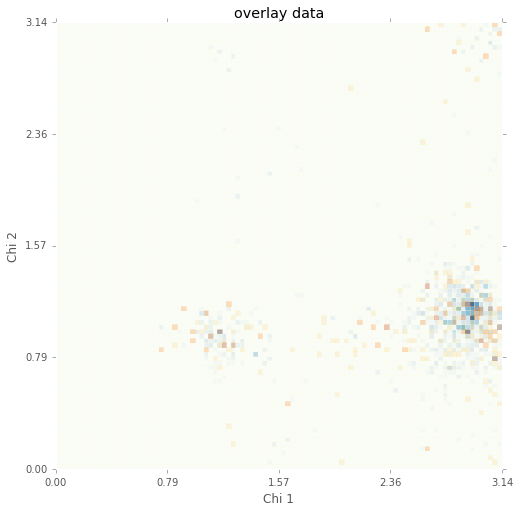

In [80]:

xedges = np.linspace(0,np.pi,100)
yedges = np.linspace(0,np.pi,100)
X, Y = np.meshgrid(xedges, yedges)
cmap1 = plt.get_cmap('Blues')
cmap2 = plt.get_cmap('YlOrBr')
ticks = np.linspace(0,np.pi,5)
tickLocator = mpl.ticker.FixedLocator(ticks)
tickFormatter = mpl.ticker.FormatStrFormatter('%.2f')

H1, xedges1, yedges1 = np.histogram2d(dataBound["chi1"].values,dataBound["chi2"].values,
                                      bins=(xedges,yedges))
H2, xedges2, yedges2 = np.histogram2d(dataUnbound["chi1"].values,dataUnbound["chi2"].values,
                                      bins=(xedges,yedges))

fig = plt.figure(figsize = (8,8),dpi = 600)
ax1 = fig.add_subplot(111)
ax1.set_title("overlay data")
ax1.pcolormesh(X,Y,H1,cmap=cmap1,alpha = 1)
ax1.pcolormesh(X,Y,H2,cmap=cmap2,alpha = 0.3)
ax1.set_aspect('equal')
ax1.xaxis.set_major_locator(copy.copy(tickLocator))
ax1.yaxis.set_major_locator(copy.copy(tickLocator))
ax1.xaxis.set_major_formatter(tickFormatter)
ax1.yaxis.set_major_formatter(tickFormatter)
ax1.xaxis.set_label_text("Chi 1")
ax1.yaxis.set_label_text("Chi 2")
plt.autoscale(True)

fig.savefig("/Users/matthias/Documents/hibit.in/development/KinStruct/overlay.png")


# ## Old stuff

### Load excel file

In [8]:

#separate because takes time

reference = pd.read_excel("/Users/matthias/Documents/hibit.in/KinaseDomainMeasures-Novartis.xlsx",
                          header=0,
                          sheetname=0,
                          parse_cols="B,C,AJ")



### Compare calculated vs reference

(old stuff, currently doesn't work because of changes in dataclass atom referencing, ergo no calculation)

In [147]:

ref_mod = reference.set_index("pdbchain",drop=False).loc[results.index]
ref_mod.loc[:,"pdbchain_unique"] = ref_mod.loc[:,"pdbchain_unique"].str.replace(r'[\S]{4}_[abe]_','')
ref_mod = ref_mod.drop_duplicates()
ref_mod = ref_mod.pivot(index="pdbchain",columns="pdbchain_unique",values="Ploop_bend6").iloc[1:,1:]
end_results = pd.concat([results,ref_mod],axis=1)

end_results["diff1"] = end_results["measured"].sub(end_results["pdb"],axis=0)
end_results["diff2"] = end_results["measured"].sub(end_results["pdbredo"],axis=0)
end_results

,measured,pdb,pdbredo,diff1,diff2
2gu8_a,10.616140,10.61610,10.61070,0.000040,0.005440
3agl_a,10.771265,10.77120,10.76240,0.000065,0.008865
3agl_b,10.741295,10.74130,10.75990,-0.000005,-0.018605
3ama_a,9.539944,9.54004,9.52416,-0.000096,0.015784
3amb_a,9.597634,9.59758,9.58747,0.000054,0.010164
3l9l_a,9.096610,9.09654,9.02010,0.000070,0.076510
3l9l_b,8.899876,8.89988,9.03277,-0.000004,-0.132894
3l9m_a,8.446536,8.44650,8.93785,0.000036,-0.491314
3l9m_b,8.862170,8.86213,8.96780,0.000040,-0.105630
3l9n_a,9.361628,9.36162,9.33039,0.000008,0.031238
